### Задача  
Проведите исследовательский анализ данных. В конце Jupyter Notebook напишите:
- Список уточняющих вопросов.
- Примерный план решения задачи. Пропишите 3–5 основных шагов, каждый поясните не более двумя предложениями. 
  
### Описание данных

Данные состоят из файлов, полученных из разных источников:

- `contract.csv` — информация о договоре;
- `personal.csv` — персональные данные клиента;
- `internet.csv` — информация об интернет-услугах;
- `phone.csv` — информация об услугах телефонии.

Во всех файлах столбец `customerID` содержит код клиента.

Информация о договорах актуальна на 1 февраля 2020.
  
Данные также находятся в тренажёре, в папке `/datasets/final_provider/`.

**1. Импортируем библиотеки и изучим данные**

In [1]:
import pandas as pd
import numpy as np
import seaborn as sn

import matplotlib.pyplot as plt
import matplotlib.style
import matplotlib as mpl
plt.style.use('seaborn')

from plotly.subplots import make_subplots
import plotly.graph_objects as go

from sklearn.metrics import SCORERS
from sklearn.metrics import roc_auc_score, accuracy_score
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, KFold
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder, PolynomialFeatures
from sklearn.utils import shuffle, resample
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from catboost import CatBoostClassifier

import warnings
warnings.filterwarnings("ignore")

pd.set_option('display.max_colwidth', -1)

In [2]:
df_contract = pd.read_csv('/datasets/final_provider/contract.csv')
df_personal = pd.read_csv('/datasets/final_provider/personal.csv')
df_internet = pd.read_csv('/datasets/final_provider/internet.csv')
df_phone = pd.read_csv('/datasets/final_provider/phone.csv')

**1.1 Объединим данные в одну таблицу**

In [3]:
df=pd.merge(left=df_contract, right=df_personal, left_on='customerID', right_on='customerID', how='outer')
df=pd.merge(left=df, right=df_internet, left_on='customerID', right_on='customerID', how='outer')
df=pd.merge(left=df, right=df_phone, left_on='customerID', right_on='customerID', how='outer')

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 20 columns):
customerID          7043 non-null object
BeginDate           7043 non-null object
EndDate             7043 non-null object
Type                7043 non-null object
PaperlessBilling    7043 non-null object
PaymentMethod       7043 non-null object
MonthlyCharges      7043 non-null float64
TotalCharges        7043 non-null object
gender              7043 non-null object
SeniorCitizen       7043 non-null int64
Partner             7043 non-null object
Dependents          7043 non-null object
InternetService     5517 non-null object
OnlineSecurity      5517 non-null object
OnlineBackup        5517 non-null object
DeviceProtection    5517 non-null object
TechSupport         5517 non-null object
StreamingTV         5517 non-null object
StreamingMovies     5517 non-null object
MultipleLines       6361 non-null object
dtypes: float64(1), int64(1), object(18)
memory usage: 1.1+ MB


In [5]:
df.head()

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,gender,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85,Female,0,Yes,No,DSL,No,Yes,No,No,No,No,NaN
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.5,Male,0,No,No,DSL,Yes,No,Yes,No,No,No,No
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15,Male,0,No,No,DSL,Yes,Yes,No,No,No,No,No
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75,Male,0,No,No,DSL,Yes,No,Yes,Yes,No,No,NaN
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65,Female,0,No,No,Fiber optic,No,No,No,No,No,No,No


- В данных есть пропуски, нужно изучить более подробно и по возможности исправить.
- В таблице есть столбцы со значениями ДА и НЕТ, нужно перевести в бинарный вид.  
- Названия столбцов нужно привести в стандартный вид.  
- Привести типы данных в порядок.

**1.2 Предварительная обработка данных.**

In [6]:
df.set_axis(['customer_id','begin_date','end_date','contract_type','paperless_billing',
                      'payment_method','monthly_charges','total_charges', 'gender', 'senior_citizen', 'partner',
                      'dependents', 'internet_service', 'online_security', 'online_backup', 'device_protection',
                      'tech_support', 'streaming_tv', 'streaming_movies', 'multiple_lines'], 
                     axis='columns', inplace=True)

In [7]:
df.head(1)

,customer_id,begin_date,end_date,contract_type,paperless_billing,payment_method,monthly_charges,total_charges,gender,senior_citizen,partner,dependents,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85,Female,0,Yes,No,DSL,No,Yes,No,No,No,No,NaN


Приведем значения Да\Нет в столбцах к 0\1.

In [8]:
def transform(df):
    for i in df.columns:
        df.loc[(df[i] == 'Yes'), i] = 1
        df.loc[(df[i] == 'No'), i] = 0
    return df

In [9]:
transform(df)
df.head()

,customer_id,begin_date,end_date,contract_type,paperless_billing,payment_method,monthly_charges,total_charges,gender,senior_citizen,partner,dependents,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines
0,7590-VHVEG,2020-01-01,0,Month-to-month,1,Electronic check,29.85,29.85,Female,0,1,0,DSL,0,1,0,0,0,0,NaN
1,5575-GNVDE,2017-04-01,0,One year,0,Mailed check,56.95,1889.5,Male,0,0,0,DSL,1,0,1,0,0,0,0
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,1,Mailed check,53.85,108.15,Male,0,0,0,DSL,1,1,0,0,0,0,0
3,7795-CFOCW,2016-05-01,0,One year,0,Bank transfer (automatic),42.30,1840.75,Male,0,0,0,DSL,1,0,1,1,0,0,NaN
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,1,Electronic check,70.70,151.65,Female,0,0,0,Fiber optic,0,0,0,0,0,0,0


Замечательно, теперь разберемся со стобцами begin_data, end_data и total_charges.
  
Поскольку у нас данные до 1 февраля 2020 года, то 0 в end_date можно заполнить этой датой. В дальнейшем это понадобится для разметки целевого признака - ушел клиент или нет.

In [10]:
df.loc[(df['end_date'] == 0), 'end_date'] = '2020-02-01'
df['end_date']=pd.to_datetime(df['end_date'], format='%Y.%m.%d')
df['begin_date']=pd.to_datetime(df['begin_date'], format='%Y.%m.%d')
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 20 columns):
customer_id          7043 non-null object
begin_date           7043 non-null datetime64[ns]
end_date             7043 non-null datetime64[ns]
contract_type        7043 non-null object
paperless_billing    7043 non-null int64
payment_method       7043 non-null object
monthly_charges      7043 non-null float64
total_charges        7043 non-null object
gender               7043 non-null object
senior_citizen       7043 non-null int64
partner              7043 non-null int64
dependents           7043 non-null int64
internet_service     5517 non-null object
online_security      5517 non-null object
online_backup        5517 non-null object
device_protection    5517 non-null object
tech_support         5517 non-null object
streaming_tv         5517 non-null object
streaming_movies     5517 non-null object
multiple_lines       6361 non-null object
dtypes: datetime64[ns](2), float64(1), i

In [11]:
df.insert(df.columns.get_loc('end_date') + 1, column='month', value='')

In [12]:
df['month'] = ((df['end_date'] - df['begin_date'])/np.timedelta64(1, 'M')).astype('int')
df.head()

,customer_id,begin_date,end_date,month,contract_type,paperless_billing,payment_method,monthly_charges,total_charges,gender,...,partner,dependents,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines
0,7590-VHVEG,2020-01-01,2020-02-01,1,Month-to-month,1,Electronic check,29.85,29.85,Female,...,1,0,DSL,0,1,0,0,0,0,NaN
1,5575-GNVDE,2017-04-01,2020-02-01,34,One year,0,Mailed check,56.95,1889.5,Male,...,0,0,DSL,1,0,1,0,0,0,0
2,3668-QPYBK,2019-10-01,2019-12-01,2,Month-to-month,1,Mailed check,53.85,108.15,Male,...,0,0,DSL,1,1,0,0,0,0,0
3,7795-CFOCW,2016-05-01,2020-02-01,45,One year,0,Bank transfer (automatic),42.30,1840.75,Male,...,0,0,DSL,1,0,1,1,0,0,NaN
4,9237-HQITU,2019-09-01,2019-11-01,2,Month-to-month,1,Electronic check,70.70,151.65,Female,...,0,0,Fiber optic,0,0,0,0,0,0,0


In [13]:
df['total_charges'] = pd.to_numeric(df['total_charges'], errors='coerce')

In [14]:
df.isna().sum()

customer_id          0   
begin_date           0   
end_date             0   
month                0   
contract_type        0   
paperless_billing    0   
payment_method       0   
monthly_charges      0   
total_charges        11  
gender               0   
senior_citizen       0   
partner              0   
dependents           0   
internet_service     1526
online_security      1526
online_backup        1526
device_protection    1526
tech_support         1526
streaming_tv         1526
streaming_movies     1526
multiple_lines       682 
dtype: int64

In [15]:
df.query('total_charges == "nan"')

,customer_id,begin_date,end_date,month,contract_type,paperless_billing,payment_method,monthly_charges,total_charges,gender,...,partner,dependents,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines
488,4472-LVYGI,2020-02-01,2020-02-01,0,Two year,1,Bank transfer (automatic),52.55,NaN,Female,...,1,1,DSL,1,0,1,1,1,0,NaN
753,3115-CZMZD,2020-02-01,2020-02-01,0,Two year,0,Mailed check,20.25,NaN,Male,...,0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
936,5709-LVOEQ,2020-02-01,2020-02-01,0,Two year,0,Mailed check,80.85,NaN,Female,...,1,1,DSL,1,1,1,0,1,1,0
1082,4367-NUYAO,2020-02-01,2020-02-01,0,Two year,0,Mailed check,25.75,NaN,Male,...,1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
1340,1371-DWPAZ,2020-02-01,2020-02-01,0,Two year,0,Credit card (automatic),56.05,NaN,Female,...,1,1,DSL,1,1,1,1,1,0,NaN
3331,7644-OMVMY,2020-02-01,2020-02-01,0,Two year,0,Mailed check,19.85,NaN,Male,...,1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
3826,3213-VVOLG,2020-02-01,2020-02-01,0,Two year,0,Mailed check,25.35,NaN,Male,...,1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
4380,2520-SGTTA,2020-02-01,2020-02-01,0,Two year,0,Mailed check,20.00,NaN,Female,...,1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
5218,2923-ARZLG,2020-02-01,2020-02-01,0,One year,1,Mailed check,19.70,NaN,Male,...,1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
6670,4075-WKNIU,2020-02-01,2020-02-01,0,Two year,0,Mailed check,73.35,NaN,Female,...,1,1,DSL,0,1,1,1,1,0,1


Все пропуски образовавшиеся после замены типа данных в total_charges можно удалить, т.к эти пользователи добавились 1 февраля 2020 года и внесли плату только за первый месяц. Удаление 11 значений не повлияет на обучение модели в дальнейшем.

In [16]:
df.dropna(subset=['total_charges'], inplace=True)

In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7032 entries, 0 to 7042
Data columns (total 21 columns):
customer_id          7032 non-null object
begin_date           7032 non-null datetime64[ns]
end_date             7032 non-null datetime64[ns]
month                7032 non-null int64
contract_type        7032 non-null object
paperless_billing    7032 non-null int64
payment_method       7032 non-null object
monthly_charges      7032 non-null float64
total_charges        7032 non-null float64
gender               7032 non-null object
senior_citizen       7032 non-null int64
partner              7032 non-null int64
dependents           7032 non-null int64
internet_service     5512 non-null object
online_security      5512 non-null object
online_backup        5512 non-null object
device_protection    5512 non-null object
tech_support         5512 non-null object
streaming_tv         5512 non-null object
streaming_movies     5512 non-null object
multiple_lines       6352 non-null objec

Теперь разберемся с пропусками в столбцах с интернет соединениями.

In [18]:
df['internet_service'].unique()

array(['DSL', 'Fiber optic', nan], dtype=object)

Пропуски после объединения заполним 'Not connected'.

In [19]:
df['internet_service'] = df['internet_service'].fillna('Not connected')
df['internet_service'].value_counts()

Fiber optic      3096
DSL              2416
Not connected    1520
Name: internet_service, dtype: int64

Пропуски в столбцах с данными об услугах интернет и телефонии заполним 0, т.к эти услуги не предоставляются.

In [20]:
df = df.fillna(0)

In [21]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7032 entries, 0 to 7042
Data columns (total 21 columns):
customer_id          7032 non-null object
begin_date           7032 non-null datetime64[ns]
end_date             7032 non-null datetime64[ns]
month                7032 non-null int64
contract_type        7032 non-null object
paperless_billing    7032 non-null int64
payment_method       7032 non-null object
monthly_charges      7032 non-null float64
total_charges        7032 non-null float64
gender               7032 non-null object
senior_citizen       7032 non-null int64
partner              7032 non-null int64
dependents           7032 non-null int64
internet_service     7032 non-null object
online_security      7032 non-null int64
online_backup        7032 non-null int64
device_protection    7032 non-null int64
tech_support         7032 non-null int64
streaming_tv         7032 non-null int64
streaming_movies     7032 non-null int64
multiple_lines       7032 non-null int64
dtype

Проверим дубликаты

In [22]:
df.duplicated().sum()

0

Добавим целевой признак target. В зависимости от того расторг клиент договор или нет, будем проставлять значения 1 и 0. Если значение в end_date не равно 2020.02.01 значит клиент ушёл ему ставим 1, в противоположном случае 0.  

In [23]:
df['target'] = np.zeros(shape=len(df)).astype('int')

In [24]:
df.loc[(df['end_date']!= '2020-02-01'), 'target'] = 1
df.head()

,customer_id,begin_date,end_date,month,contract_type,paperless_billing,payment_method,monthly_charges,total_charges,gender,...,dependents,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines,target
0,7590-VHVEG,2020-01-01,2020-02-01,1,Month-to-month,1,Electronic check,29.85,29.85,Female,...,0,DSL,0,1,0,0,0,0,0,0
1,5575-GNVDE,2017-04-01,2020-02-01,34,One year,0,Mailed check,56.95,1889.50,Male,...,0,DSL,1,0,1,0,0,0,0,0
2,3668-QPYBK,2019-10-01,2019-12-01,2,Month-to-month,1,Mailed check,53.85,108.15,Male,...,0,DSL,1,1,0,0,0,0,0,1
3,7795-CFOCW,2016-05-01,2020-02-01,45,One year,0,Bank transfer (automatic),42.30,1840.75,Male,...,0,DSL,1,0,1,1,0,0,0,0
4,9237-HQITU,2019-09-01,2019-11-01,2,Month-to-month,1,Electronic check,70.70,151.65,Female,...,0,Fiber optic,0,0,0,0,0,0,0,1


**Вывод**  
Подготовили данные для дальнейшего анализа. Удалили пропуски, привели данные к соответствующим типам, добавили целевой признак. Можно переходить к исследовательскому анализу.

**1.3 Исследовательский анализ данных.**

Посмотрим сколько людей ушли

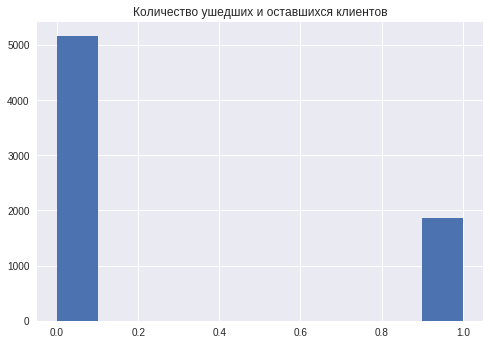

In [25]:
df['target'].hist()
plt.title('Количество ушедших и оставшихся клиентов')
plt.show()

In [26]:
print(df['target'].value_counts()/len(df)*100)

0    73.421502
1    26.578498
Name: target, dtype: float64


26.5% пользователей расторгли договоры и ушли к другому оператору. Также есть дисбаланс классов 4 к 1.  
  
Рассмотрим подробнее какие пользователи ушли.

In [27]:
out = df[df["target"] == 1].sort_values("target")
out_contract = out.groupby('contract_type')['target'].count()

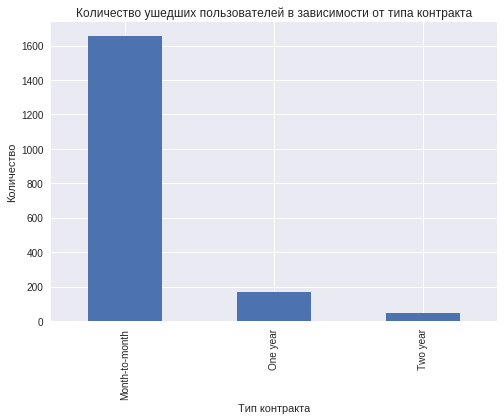

In [28]:
out_contract.plot(kind='bar')
plt.title('Количество ушедших пользователей в зависимости от типа контракта')
plt.xlabel('Тип контракта')
plt.ylabel('Количество')
plt.show()

Больше всего пользователей ушли с оплатой по месяцам

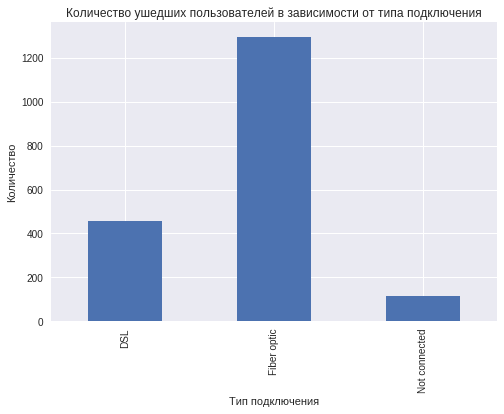

In [29]:
out_internet_service = out.groupby('internet_service')['target'].count()
out_internet_service.plot(kind='bar')
plt.title('Количество ушедших пользователей в зависимости от типа подключения')
plt.xlabel('Тип подключения')
plt.ylabel('Количество')
plt.show()

Больше всего пользователей ушли с оптоволокна

Посмотрим сколько платили в месяц ушедшие пользователи

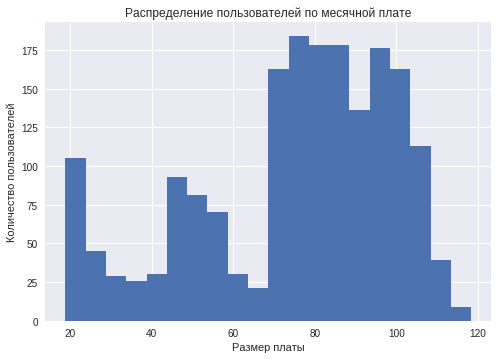

In [30]:
out['monthly_charges'].plot(kind='hist', bins=20)
plt.title('Распределение пользователей по месячной плате')
plt.xlabel('Размер платы')
plt.ylabel('Количество пользователей')
plt.show()

Большая часть ушедших пользователей платила больше 70 у.е. в месяц. Также есть пики при цене от 40 до 60 и 20 у.е.

Посмотрим какими услугами пользовались ушедшие клиенты.

In [31]:
out_service = out.groupby('internet_service')['online_security', 'online_backup','device_protection', 'tech_support',
                                              'streaming_tv', 'streaming_movies', 'multiple_lines'].sum()
out_service

,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines
internet_service,,,,,,,
DSL,112,116,117,114,127,137,73
Fiber optic,183,407,428,196,687,681,767
Not connected,0,0,0,0,0,0,10


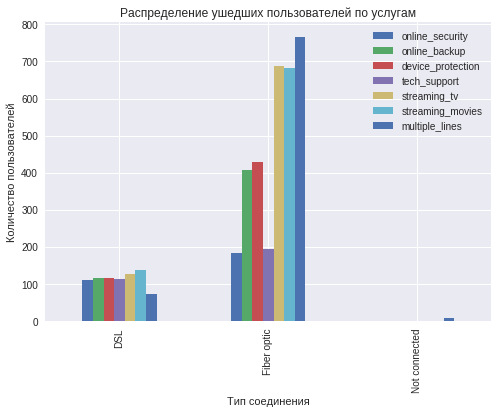

In [32]:
out_service.plot(kind='bar')
plt.title('Распределение ушедших пользователей по услугам')
plt.xlabel('Тип соединения')
plt.ylabel('Количество пользователей')
plt.show()

По оттоку клиентов лидирует оптоволокно с подключенеем многоканальной линии для телефона, кабельное тв и каталог фильмов(может каналы не нравятся пользователям и католог фильмов не очень). Далее идут антивирус и облочное хранилище данных. 

**Вывод**  
  
1) Провели предобработку данных, заполнили пропуски, разметили целевой признак.  
2) Провели исследовательский анализ данных:  
- на 1 февраля 2020 года ушло 26.5% пользователей;  
- большая часть пользователей, которые ушли платила каждый месяц в размере больше 70 у.е. и пользовалась услугами интернет через оптоволоконное соединение;
- По подключенным услугам у отключившихся пользователей лидирует многоканальная линия, кабельное тв и каталог фильмов, затем антивирус и облочное хранилище.  
  
Возможно заказчику стоит дополнительно изучить вопрос абонентской платы и ассортимент каналов и фильмов.

### План дальнейшей работы  
1) Подготовить данные для обучения модели.
Обработать категориальные переменные, масштабировать признаки, т.к есть дисбаланс классов, разбить данные на выборки.  
2) Обучить модели.  
Так как предстоит решить задачу классификации, можно использовать стандартные модели логистическую регрессию, дерево и случайный лес. Подобрать гиперпараметры моделей и выбрать наилучшую.  
3) Проверить модель на тестовой выборке.  
4) Проверить модель на адекватность.  
Стандартным классификатором DummyClassifier из библиотеки Skelarn.  



### Подготовка данных для обучения модели.

Посмотрим на корреляцию количественных признаков.

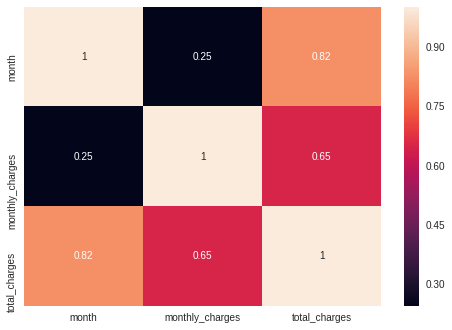

In [33]:
df_corr = df.loc[:,['month', 'monthly_charges', 'total_charges']]
corrMatrix = df_corr.corr()
sn.heatmap(corrMatrix, annot=True)
plt.show()

Сильная корреляция между временем жизни и общей выручкой.

Удалим лишние признаки customer_id, begin_date, end_date, total_charges.

In [34]:
df=df.drop(['customer_id', 'begin_date', 'end_date', 'total_charges'], axis=1)

In [35]:
df.head()

,month,contract_type,paperless_billing,payment_method,monthly_charges,gender,senior_citizen,partner,dependents,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines,target
0,1,Month-to-month,1,Electronic check,29.85,Female,0,1,0,DSL,0,1,0,0,0,0,0,0
1,34,One year,0,Mailed check,56.95,Male,0,0,0,DSL,1,0,1,0,0,0,0,0
2,2,Month-to-month,1,Mailed check,53.85,Male,0,0,0,DSL,1,1,0,0,0,0,0,1
3,45,One year,0,Bank transfer (automatic),42.30,Male,0,0,0,DSL,1,0,1,1,0,0,0,0
4,2,Month-to-month,1,Electronic check,70.70,Female,0,0,0,Fiber optic,0,0,0,0,0,0,0,1


Разделим данные на фичи и таргет.

In [36]:
features = df.drop('target', axis=1)
target = df['target']

In [37]:
def upsample(features, target, repeat):
    
    '''
    
    Функция для увеличение выборки (upsampling).
    Как аргументы ф-я принимает признаки (features), целевой признак (target) и к-во повторений (repeat).
    
    Ф-я работает по следующему принципу:
        - разделяет обучающую выборку на отрицательные и положительные объекты
        - копирует несколько раз положительные объекты
        - создает новую обучающую выборку с учётом полученных данных
        - перемешивает данные
        - возвращает преобразованные выборки.    
    
    '''
    
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)
    
    features_upsampled, target_upsampled = shuffle(features_upsampled, target_upsampled, random_state=123)
    
    return features_upsampled, target_upsampled



Разделим данные на обучающую и тестовую выборки.

In [38]:
feature_train, features_test, target_train, target_test = train_test_split(features, 
                                                                           target, 
                                                                           test_size=0.2, 
                                                                           random_state=123)

In [39]:
print(feature_train.shape, features_test.shape, target_train.shape, target_test.shape)

(5625, 17) (1407, 17) (5625,) (1407,)


In [40]:
features_upsampled, target_upsampled = upsample(feature_train, target_train, 4)

In [41]:
features_upsampled.shape

(9999, 17)

### Обучение модели.

**CatBoost**

In [42]:
feature_train.columns

Index(['month', 'contract_type', 'paperless_billing', 'payment_method',
       'monthly_charges', 'gender', 'senior_citizen', 'partner', 'dependents',
       'internet_service', 'online_security', 'online_backup',
       'device_protection', 'tech_support', 'streaming_tv', 'streaming_movies',
       'multiple_lines'],
      dtype='object')

In [43]:
numeric = ['month', 'monthly_charges']

scaler = StandardScaler()
scaler.fit(feature_train[numeric])

feature_train[numeric] = scaler.transform(feature_train[numeric])
features_test[numeric] = scaler.transform(features_test[numeric])

In [44]:
feature_train.sample()

,month,contract_type,paperless_billing,payment_method,monthly_charges,gender,senior_citizen,partner,dependents,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines
6989,-0.505106,One year,0,Bank transfer (automatic),0.363023,Female,0,1,1,DSL,1,0,0,0,1,1,1


In [45]:
cv = KFold(n_splits=3, shuffle=True, random_state=123)

cat_features = ['contract_type', 'payment_method', 'gender', 'internet_service']

cbr = CatBoostClassifier(random_seed=123,
                        loss_function='Logloss',
                        silent=True,
                        cat_features=cat_features)

params = {
    'learning_rate': np.logspace(-3, 0, 5),
    'iterations': [80, 90, 100],
    'depth': [6,8,10],
}

grid_cbr = GridSearchCV(cbr,
                        params,
                        cv=cv,
                        n_jobs=-1,
                        scoring='roc_auc',
                        verbose=False)

In [46]:
#%%time
#grid_cbr.fit(feature_train, target_train)

In [47]:
#grid_cbr.best_params_

In [48]:
cbr1 = CatBoostClassifier(random_seed=123,
                        loss_function='Logloss',
                        depth=10,
                        iterations=100,
                        learning_rate=0.0316,
                        silent=True,
                        cat_features=cat_features)
cbr1.fit(feature_train, target_train)

In [49]:
print('roc_auc: ',roc_auc_score(target_train, cbr1.predict(feature_train)))
print('accuracy: ',accuracy_score(target_train, cbr1.predict(feature_train)))

roc_auc:  0.7221622270218383
accuracy:  0.8291555555555555


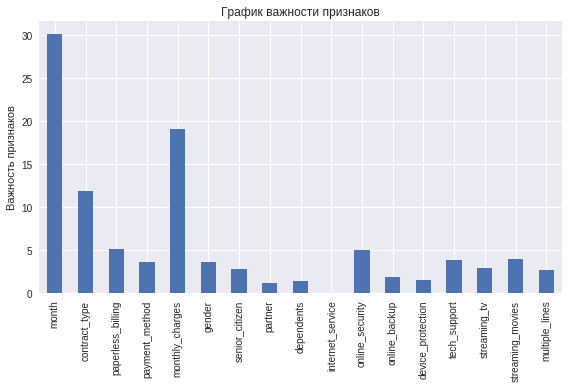

In [50]:

feature_names = feature_train.columns
importance = cbr1.get_feature_importance()


forest_importances = pd.Series(importance, index=feature_names)

fig, ax = plt.subplots()
forest_importances.plot.bar(importance, ax=ax)
ax.set_title("График важности признаков")
ax.set_ylabel("Важность признаков")
fig.tight_layout()

Для кота не так важны признаки с подключенными услугами и возраст пользователя. Попробуем их удалить и обучить заново модель.

In [51]:
feature_train = feature_train.drop(['paperless_billing', 'senior_citizen', 'partner', 'dependents', 
                                    'online_security', 'online_backup', 'device_protection',
                                    'tech_support', 'streaming_tv', 'streaming_movies', 'multiple_lines'], axis=1)

features_test = features_test.drop(['paperless_billing', 'senior_citizen', 'partner', 'dependents', 
                                    'online_security', 'online_backup', 'device_protection',
                                    'tech_support', 'streaming_tv', 'streaming_movies', 'multiple_lines'], axis=1)

In [52]:
cbr2 = CatBoostClassifier(random_seed=123,
                        loss_function='Logloss',
                        depth=10,
                        iterations=100,
                        learning_rate=0.03,
                        silent=True,
                        cat_features=cat_features)
cbr2.fit(feature_train, target_train)

In [53]:
print('roc_auc: ',roc_auc_score(target_train, cbr2.predict_proba(feature_train)[:,1]))
print('accuracy: ',accuracy_score(target_train, cbr2.predict(feature_train)))

roc_auc:  0.8523192218696578
accuracy:  0.8117333333333333


**LogisticRegression**

Преобразуем категориальные признаки в колличественные.

In [54]:
df_ohe = pd.get_dummies(df, drop_first=True)
df_ohe.head()

,month,paperless_billing,monthly_charges,senior_citizen,partner,dependents,online_security,online_backup,device_protection,tech_support,...,multiple_lines,target,contract_type_One year,contract_type_Two year,payment_method_Credit card (automatic),payment_method_Electronic check,payment_method_Mailed check,gender_Male,internet_service_Fiber optic,internet_service_Not connected
0,1,1,29.85,0,1,0,0,1,0,0,...,0,0,0,0,0,1,0,0,0,0
1,34,0,56.95,0,0,0,1,0,1,0,...,0,0,1,0,0,0,1,1,0,0
2,2,1,53.85,0,0,0,1,1,0,0,...,0,1,0,0,0,0,1,1,0,0
3,45,0,42.30,0,0,0,1,0,1,1,...,0,0,1,0,0,0,0,1,0,0
4,2,1,70.70,0,0,0,0,0,0,0,...,0,1,0,0,0,1,0,0,1,0


Разделим данные на признаки.

In [55]:
features_lr = df_ohe.drop('target', axis=1)
target_lr = df_ohe['target']

In [56]:
features_lr_train, features_lr_test, target_lr_train, target_lr_test = train_test_split(features_lr, 
                                                                              target_lr,                                                                               
                                                                              test_size=0.2, 
                                                                              random_state=123)

In [57]:
features_lr_upsampled, target_lr_upsampled = upsample(features_lr_train, target_lr_train, 4)

In [58]:
print(features_lr_upsampled.shape, features_lr_test.shape)

(9999, 21) (1407, 21)


Масштабируем признаки.

In [59]:
numeric = ['month', 'monthly_charges']

scaler = StandardScaler()
scaler.fit(features_lr_train[numeric])

features_lr_train[numeric] = scaler.transform(features_lr_train[numeric])
features_lr_test[numeric] = scaler.transform(features_lr_test[numeric])

In [60]:
features_lr_train.sample()

,month,paperless_billing,monthly_charges,senior_citizen,partner,dependents,online_security,online_backup,device_protection,tech_support,...,streaming_movies,multiple_lines,contract_type_One year,contract_type_Two year,payment_method_Credit card (automatic),payment_method_Electronic check,payment_method_Mailed check,gender_Male,internet_service_Fiber optic,internet_service_Not connected
2306,-1.198982,1,0.157989,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,1,0


In [61]:
%%time
model_lr = LogisticRegression(solver='liblinear', class_weight='balanced', random_state=123)
model_lr.fit(features_lr_train, target_lr_train)
predictions_lr = model_lr.predict(features_lr_train)

CPU times: user 19 ms, sys: 3.81 ms, total: 22.9 ms
Wall time: 44 ms


In [62]:
print('roc_auc: ',roc_auc_score(target_lr_train, predictions_lr))
print('accuracy: ',accuracy_score(target_lr_train, predictions_lr))

roc_auc:  0.7659194671833661
accuracy:  0.7489777777777777


**RandomForestClassifier**

In [63]:
model_rfc = RandomForestClassifier(
    random_state=123,
    class_weight='balanced',
    n_jobs=-1)

params = {
    'n_estimators': [60,80,100,110,120],
    'max_depth': [5,6,7,9,11]
}

grid_rfc = GridSearchCV(model_rfc,
                        params,
                        n_jobs=-1,
                        scoring='roc_auc',
                        verbose=False)

In [64]:
%%time
grid_rfc.fit(features_lr_train, target_lr_train)

CPU times: user 21.9 s, sys: 0 ns, total: 21.9 s
Wall time: 22.1 s


GridSearchCV(cv='warn', error_score='raise-deprecating',
             estimator=RandomForestClassifier(bootstrap=True,
                                              class_weight='balanced',
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators='warn', n_jobs=-1,
                                              oob_score=False, random_state=123,
                                              verbose=0, warm_start=False),
        

In [65]:
grid_rfc.best_params_

{'max_depth': 7, 'n_estimators': 100}

In [66]:
model_rfc1 = RandomForestClassifier(
    random_state=123,
    max_depth=7,
    n_estimators=100,
    class_weight='balanced',
    n_jobs=-1)

model_rfc1.fit(features_lr_train, target_lr_train)

RandomForestClassifier(bootstrap=True, class_weight='balanced',
                       criterion='gini', max_depth=7, max_features='auto',
                       max_leaf_nodes=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=-1, oob_score=False,
                       random_state=123, verbose=0, warm_start=False)

In [67]:
print('roc_auc: ',roc_auc_score(target_lr_train, model_rfc1.predict(features_lr_train)))
print('accuracy: ',accuracy_score(target_lr_train, model_rfc1.predict(features_lr_train)))

roc_auc:  0.7970866034420949
accuracy:  0.7829333333333334


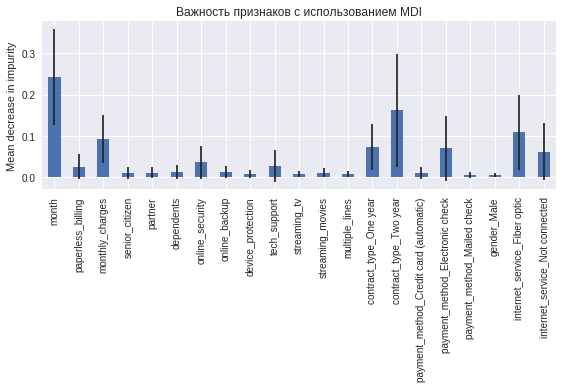

In [68]:
feature_names = features_lr_train.columns
importance = model_rfc1.feature_importances_

std = np.std([tree.feature_importances_ for tree in model_rfc1.estimators_], axis=0)
forest_importances = pd.Series(importance, index=feature_names)

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Важность признаков с использованием MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

По графику видно, какие фичи модель считает более важными. повторим теже действия, что и с котом и посмотрим на результат.

In [69]:
features_lr_train = features_lr_train.drop(['paperless_billing', 'senior_citizen', 'partner', 'dependents', 
                                    'online_security', 'online_backup', 'device_protection',
                                    'tech_support', 'streaming_tv', 'streaming_movies', 'multiple_lines'], axis=1)

features_lr_test = features_lr_test.drop(['paperless_billing', 'senior_citizen', 'partner', 'dependents', 
                                    'online_security', 'online_backup', 'device_protection',
                                    'tech_support', 'streaming_tv', 'streaming_movies', 'multiple_lines'], axis=1)

In [70]:
model_rfc2 = RandomForestClassifier(
    random_state=123,
    max_depth=7,
    n_estimators=100,
    class_weight='balanced',
    n_jobs=-1)

model_rfc2.fit(features_lr_train, target_lr_train)

RandomForestClassifier(bootstrap=True, class_weight='balanced',
                       criterion='gini', max_depth=7, max_features='auto',
                       max_leaf_nodes=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=-1, oob_score=False,
                       random_state=123, verbose=0, warm_start=False)

In [71]:
print('roc_auc: ',roc_auc_score(target_lr_train, model_rfc2.predict_proba(features_lr_train)[:,1]))
print('accuracy: ',accuracy_score(target_lr_train, model_rfc2.predict(features_lr_train)))

roc_auc:  0.8785476585741453
accuracy:  0.7793777777777777


После обучения моделей, получили следующие показатели:  
  
- CatBoost: 
roc_auc:  0.85  
accuracy:  0.81  
CPU times: user 52min 41s, sys: 5min 6s, total: 57min 48s  
Wall time: 1h 55s  
  
- LogisticRegression:  
roc_auc:  0.77  
accuracy:  0.75  
CPU times: user 36.8 ms, sys: 8.26 ms, total: 45.1 ms   
Wall time: 42.7 ms  
  
- RandomForestClassifier:  
roc_auc:  0.88  
accuracy:  0.78  
CPU times: user 31.1 s, sys: 79.6 ms, total: 31.2 s  
Wall time: 31.2 s  
  
По целевой метрике roc_auc лидирует случайный лес и кот. По времени обучения случайный лес, 31 сек, против почти часа у кота.  Проверим эти модели на тестовой выборке. CatBoost закомментирую, чтобы не обучать много раз и не тратить время.

### Тестирование моделей.

**CatBoost**

In [72]:
print('roc_auc: ',roc_auc_score(target_test, cbr2.predict_proba(features_test)[:,1]))
print('accuracy: ',accuracy_score(target_test, cbr2.predict(features_test)))

roc_auc:  0.859865251761303
accuracy:  0.8081023454157783


**RandomForestClassifier**

In [73]:
print('roc_auc: ',roc_auc_score(target_lr_test, model_rfc2.predict_proba(features_lr_test)[:,1]))
print('accuracy: ',accuracy_score(target_lr_test, model_rfc2.predict(features_lr_test)))

roc_auc:  0.8638898660334771
accuracy:  0.7825159914712153


При проверке моделей, обе показали сопоставимые результаты на тестовой выборке, но случайный лес обучается быстрее. Стоит отдать предпочтение ему.  
  
CatBoost    
roc_auc:  0.8598  
accuracy:  0.8081  
  
RandomForestClassifier  
roc_auc:  0.8638  
accuracy:  0.7825

### Проверка моделей на адекватность.

In [74]:
strategies = ['stratified', 'most_frequent', 'uniform'] 
  
dummy_results = [] 
for strategy in strategies: 
    dc = DummyClassifier(strategy = strategy, random_state = 123)
    
    dc.fit(feature_train, target_train) 
    result = dc.score(features_test, target_test) 
    dummy_results.append({strategy: result}) 

pd.DataFrame(dummy_results).style.highlight_max(color = 'lightgreen', axis = 1)

,stratified,most_frequent,uniform
0,0.59204,nan,nan
1,nan,0.707889,nan
2,nan,nan,0.471926


Выбранная нами модель, предсказывает лучше, чем DummyClassifier.

**Вывод**  
  
1) Подготовили данные для обучения моделей, удалили лишние признаки, убрали дисбаланс классов с помощью upsampl'инга, разделили данные на выборки и масштабировали количественные признаки. Для моделей регресии и случайного леса, дополнительно провели кодирование категориальных переменных.
  
2) Обучили 3 модели: CatBoost, LogisticRegression и RandomForestClassifier. Лучшие результаты по целевой метрике roc_auc, показали кот и случайный лес:  
- CatBoost: roc_auc: 0.98
  accuracy: 0.98
  CPU times: user 52min 41s, sys: 5min 6s, total: 57min 48s
  Wall time: 1h 55s  
- RandomForestClassifier:
  roc_auc: 0.97
  accuracy: 0.97
  CPU times: user 31.1 s, sys: 79.6 ms, total: 31.2 s
  Wall time: 31.2 s  
  
  Для дальнейшего тестирования были выбраны эти модели.  
  
3) При тестировании обе модели показали сопоставимый результат, но случайный лес был чуть лучше:  
- CatBoost
  roc_auc: 0.8598  
  accuracy: 0.8081    
  
- RandomForestClassifier  
  roc_auc: 0.8638  
  accuracy: 0.7825    
  
  Из-за того, модель леса быстрее обучается стоит отдать предпочтение ей.
  
4) Проверили модели на адекватность, обе модели предсказывают лучше, чем стандартный классификатор.

Ответы на вопросы:  
1) Есть корреляция между month и total_charges больше 0.8. Удалили из признаков total_charges.  
2) Построил график важности факторов для кота и леса. Удалили менее значимые признаки.  
3) Исправил балансировку.


<div style="background: #cceeaa; padding: 5px; border: 1px solid green; border-radius: 5px;">
    <font color='green'> <b><u>КОММЕНТАРИЙ РЕВЬЮЕРА 2</u></b>
</font>
<font color='green'><br>
Привет, Евгений!<br>
Увидел твои длоработки. ОК, всё ао делу и в точку)<br>
 
Что ж, получается, что всё на этом...<br>   
Спасибо за этот труд и за совместную работу на других проектах)<br>
Искренне желаю покорить ещё не один аналитический Эверест)<br>

### Отчет.

В процессе решения поставленной задачи выполнил все пункты плана.  
  
1) Подготовить данные для обучения модели.
Обработать категориальные переменные, масштабировать признаки, т.к есть дисбаланс классов, разбить данные на выборки.  
2) Обучить модели.  
Так как предстоит решить задачу классификации, можно использовать стандартные модели логистическую регрессию, дерево и случайный лес. Подобрать гиперпараметры моделей и выбрать наилучшую.
  
При обучении моделей отказался от использования дерева решений, захотел попробовать бустинг.  
  
3) Проверить модель на тестовой выборке.  
4) Проверить модель на адекватность.  
Стандартным классификатором DummyClassifier из библиотеки Skelarn.  
  
Трудностей при выполнении проекта не возникало, если возникали вопросы, то было достаточно заглянуть в документацию или погуглить. 
  
Из ключевых моментов стоит выделить предподготовку данных, которой было уделено большое внимание, т.к. от этого зависит итоговое качество модели. 
На этапе обучения моделей выбрал наиболее перспективные по целевой метрике roc_auc и дополнительно посмотрел feature_importances_. Это позволило очистить данные от признаков, которые модель считала не значимыми при составлении прогноза. Благодаря этому мы смогли снизить переобучение модели и повысить скорость обучения.  
На этам тестирования было допущено две модели: CatBoost и RandomForestClassifier.   
  
В качестве итоговой модели выбрал RandomForestClassifier с показателями:
- roc_auc: 0.8638  
- accuracy: 0.7825  